In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [ ]:
data = pd.read_csv("data/Constraint_Train.csv")
# true = pd.read_csv("data/True.csv")

In [ ]:
# fake.shape

In [ ]:
# true.shape

## Data cleaning and preparation

In [ ]:
# Add flag to track fake and real
# fake['target'] = 'fake'
# true['target'] = 'true'

In [ ]:
# Concatenate dataframes
# data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(6420, 3)

In [ ]:
# # Shuffle the data
# from sklearn.utils import shuffle
# data = shuffle(data)
# # data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["id"],axis=1,inplace=True)
data.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


In [ ]:
# # Removing the title (we will only use the text)
# data.drop(["title"],axis=1,inplace=True)
# data.head()

In [ ]:
# Convert to lowercase

data['tweet'] = data['tweet'].apply(lambda x: x.lower())
data.head()

,tweet,label
0,the cdc currently reports 99031 deaths. in gen...,real
1,states reported 1121 deaths a small rise from ...,real
2,politically correct woman (almost) uses pandem...,fake
3,#indiafightscorona: we have 1524 #covid testin...,real
4,populous states can generate large case counts...,real


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['tweet'] = data['tweet'].apply(punctuation_removal)

In [ ]:
# Check
data.head()

,tweet,label
0,the cdc currently reports 99031 deaths in gene...,real
1,states reported 1121 deaths a small rise from ...,real
2,politically correct woman almost uses pandemic...,fake
3,indiafightscorona we have 1524 covid testing l...,real
4,populous states can generate large case counts...,real


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,tweet,label
0,cdc currently reports 99031 deaths general dis...,real
1,states reported 1121 deaths small rise last tu...,real
2,politically correct woman almost uses pandemic...,fake
3,indiafightscorona 1524 covid testing laborator...,real
4,populous states generate large case counts loo...,real


## Basic data exploration

label
fake    3060
real    3360
Name: tweet, dtype: int64


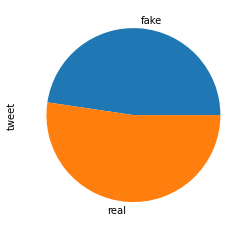

In [ ]:
# How many fake and real articles?
print(data.groupby(['label'])['tweet'].count())
data.groupby(['label'])['tweet'].count().plot(kind="pie")
plt.show()

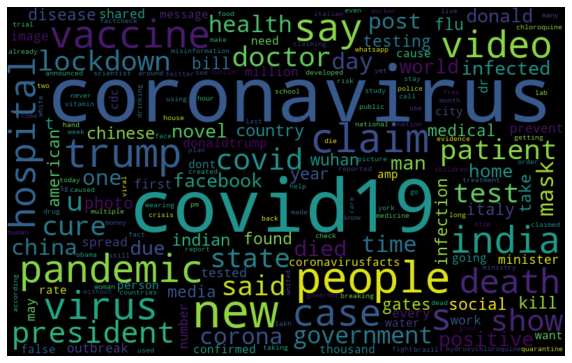

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["label"] == "fake"]
all_words = ' '.join([text for text in fake_data.tweet])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

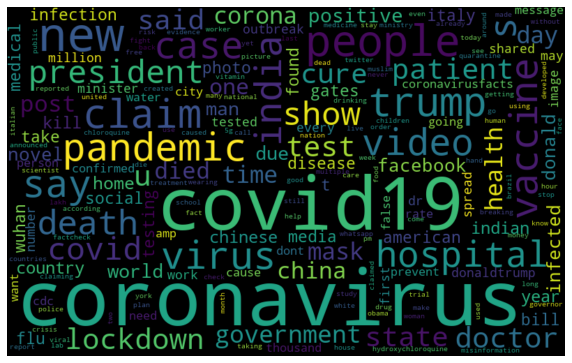

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["label"] == "real"]
all_words = ' '.join([text for text in fake_data.tweet])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

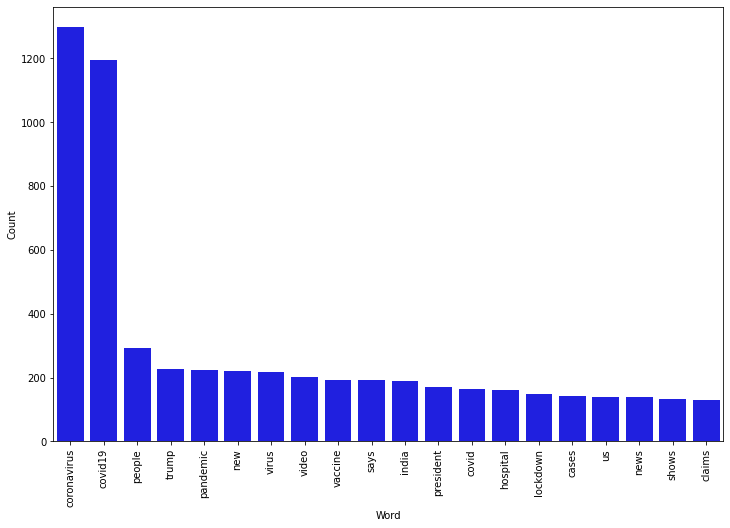

In [ ]:
# Most frequent words in fake news
counter(data[data["label"] == "fake"], "tweet", 20)

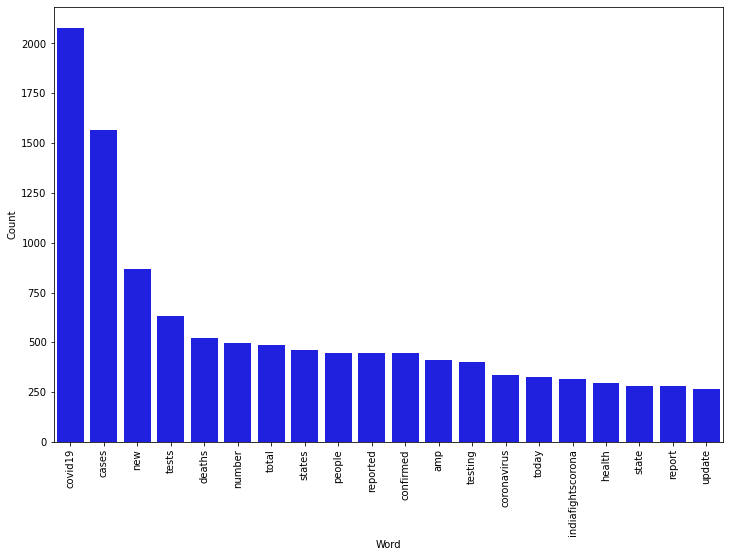

In [ ]:
# Most frequent words in real news
counter(data[data["label"] == "real"], "tweet", 20)

## Modeling

In [ ]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['tweet'], data.label, test_size=0.2, random_state=42)

# **Naive Bayes**




In [ ]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)


prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

# custom = ['6969', "aman is the new president of india", "News","fake"]
# customX = ["My name is kumar vishwas"]
# customY = ["false"]

# prediction = model.predict(customX)

# print("accuracy: {}%".format(round(accuracy_score(customY, prediction)*100,2)))
# print(prediction)
# dct['Naive Bayes'] = round(accuracy_score(customY, prediction)*100,2)

accuracy: 89.56%


Confusion matrix, without normalization


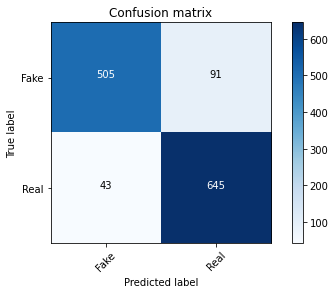

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
# TESTING

# **Logistic regression**

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 90.58%


Confusion matrix, without normalization


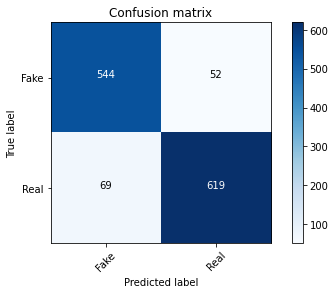

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# model = pipe.fit(["Donald Trump never became the president of United States"], ["false"])

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

# customX = ["Donald Trump never became the president of United States"]
# customY = ["false"]

# prediction = model.predict(customX)
# print("accuracy: {}%".format(round(accuracy_score(customY, prediction)*100,2)))

accuracy: 79.52%


Confusion matrix, without normalization


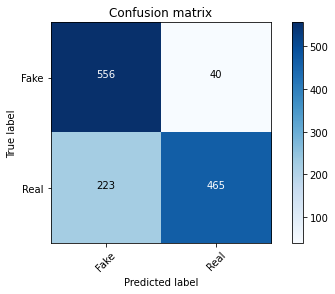

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 89.41%


Confusion matrix, without normalization


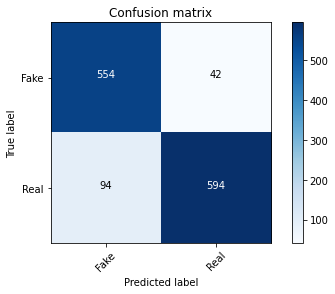

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 91.59%


Confusion matrix, without normalization


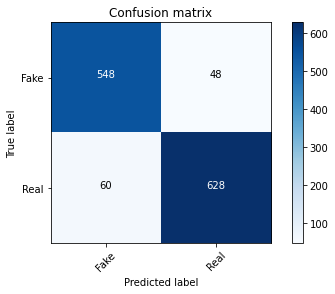

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x2379bc858e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

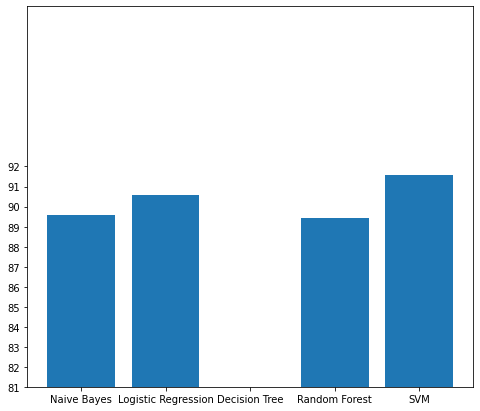

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92))

In [ ]:
the end.....

SyntaxError: invalid syntax (Temp/ipykernel_304/2237372829.py, line 1)